In [74]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Keeps notebooks clean 
import warnings
warnings.filterwarnings("ignore") 


from datetime import datetime
from collections import namedtuple

In [2]:
!pip install geopandas

In [3]:
import geopandas as gpd

In [4]:
pwd

'/Users/Monika/Projects'

In [5]:
df_collisions = pd.read_csv('data/collisions_orig.csv', parse_dates=["INCDTTM"])
df_locations_xy = pd.read_csv('data/location_xy.csv')

In [6]:
# Check the starting shape
df_collisions.shape

(220436, 40)

In [7]:
# Save column list to restore column order after merge
column_list = df_collisions.columns
column_list = column_list.append(pd.Index(['fe_exists']))

In [8]:
# Drop the old X,Y and replace with the ones in location_xy.csv if they exist, otherwise, will be nan
df_collisions.drop(columns=['X','Y'],inplace=True,errors='ignore')   # get these from the location_xy.csv file
df_collisions.shape

(220436, 38)

In [9]:
df_new = pd.merge(df_collisions, df_locations_xy, on='LOCATION', how='left')

In [10]:
# Do some sanity checks
df_new.shape

(220436, 41)

In [11]:
# Restore the original order of columns
df_new = df_new[column_list]

In [12]:
df_new.drop_duplicates(inplace=True)

In [13]:
df_new['fe_exists'].value_counts()

1    216059
0      4377
Name: fe_exists, dtype: int64

In [14]:
new_keys = list(df_new['INCKEY'])
col_keys = list(df_collisions['INCKEY'])
print(f"{len(new_keys)}   {len(col_keys)}")

220436   220436


In [15]:
#Dropping columns deemed unnecessary
df_new.drop(['EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'STATUS', 'REPORTNO', 'SEGLANEKEY', 'CROSSWALKKEY', 'INCKEY','COLDETKEY'],axis=1, inplace=True)

In [16]:
#to lowercase
df_new.columns = df_new.columns.str.lower()

In [17]:
df_new.columns

Index(['x', 'y', 'objectid', 'addrtype', 'intkey', 'location', 'severitycode',
       'severitydesc', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'incdate', 'incdttm', 'junctiontype', 'sdot_colcode', 'sdot_coldesc',
       'inattentionind', 'underinfl', 'weather', 'roadcond', 'lightcond',
       'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode', 'st_coldesc',
       'hitparkedcar', 'fe_exists'],
      dtype='object')

In [18]:
print(df_new['x'].isnull().sum())
print(df_new['y'].isnull().sum())

7189
7189


In [19]:
#FE time, total_injuries and total_person_count columns
df_new["time"]=df_new['incdttm'].dt.strftime('%H:%M')
df_new["total_injuries"]=df_new['injuries'] + df_new['seriousinjuries']  + df_new['fatalities']
df_new["total_person_count"]=df_new['personcount'] + df_new['pedcount']  + df_new['pedcylcount']

In [20]:
#FE emd column for the missing 26,000
fe_emd_crit = (df_new['weather'].isnull() &
    df_new['lightcond'].isnull() &
    df_new['roadcond'].isnull() &
    df_new['collisiontype'].isnull() &
    df_new['st_coldesc'].isnull() &
    df_new['underinfl'].isnull() &
    df_new['inattentionind'].isnull() &
    df_new['speeding'].isnull() &
    df_new['pedrownotgrnt'].isnull() &
    (df_new['vehcount'] == 0))
df_new['fe_emd'] = fe_emd_crit

In [21]:
#converting incdate to datetime
df_new["incdate"] = df_new["incdate"].astype("datetime64")

In [22]:
#Rebecca's contribution: filling in missing values
categories = ["addrtype", "collisiontype", "severitydesc", "lightcond",
             "speeding", "junctiontype", "roadcond", "weather"]

for col in categories:
    df_new[col] = df_new[col].replace({np.nan: "Unknown", "Other": "Unknown"})
    
df_new["pedrownotgrnt"] = df_new["pedrownotgrnt"].replace({np.nan: "N"})    

# While we are at it, let's go ahead and clean up missing values for these two:
df_new["st_coldesc"] = df_new["st_coldesc"].replace({np.nan: "Unknown"})  
df_new["sdot_coldesc"] = df_new["sdot_coldesc"].replace({np.nan: "Unknown"})

df_new["underinfl"] = df_new["underinfl"].replace({"0": "N", "1": "Y", np.nan: "X"})

In [23]:
#df2 = df_new.set_index('incdate') #change index to incdate 
#df2['2004-01-02'] 

In [24]:
#df2.loc['2004-01-02']['weather'].value_counts()

In [25]:
#Jeny - work in progress
#for each column, get value counts in decreasing order and take the index (value) of most common class
#weather_imputed = df2.apply(lambda x: x.fillna(x.value_counts().ind))
#df_most_common_imputed = colors.apply(lambda x: x.fillna(x.value_counts().index[0]))
#df_most_common_imputed

#df2['weather'] = df2['weather'].apply(lambda x: x.fillna(x.value_counts().index[0]))

In [26]:
#Niwako's contribution for collision codes
labels = list(df_new['st_coldesc'].unique())
labels

['Vehicle backing hits pedestrian',
 'Unknown',
 'Entering at angle',
 'From same direction - both going straight - both moving - sideswipe',
 'From same direction - all others',
 'One car entering driveway access',
 'From opposite direction - one left turn - one straight',
 'From same direction - both going straight - one stopped - rear-end',
 'Fixed object',
 'From same direction - both going straight - both moving - rear-end',
 'One parked--one moving',
 'Same direction -- both turning right -- both moving -- sideswipe',
 'Pedalcyclist Strikes Moving Vehicle',
 'Breakage of any part of the vehicle resulting in injury or in further property damage',
 'One car leaving parked position',
 'From opposite direction - both going straight - one stopped - sideswipe',
 'From same direction - both going straight - one stopped - sideswipe',
 'Same direction -- both turning right -- one stopped -- rear end',
 'Same direction -- both turning left -- both moving -- sideswipe',
 'From same directio

In [27]:
vehicle_only_labels = [
    label 
    for label in df_new['st_coldesc'].dropna().unique() 
    if label.startswith('From same direction')
    or label.startswith('From opposite direction')
    or label.startswith('One car')
    or label.startswith('One parked')
    or label.startswith('Vehicle overturned')
    or label.startswith('All Other Multi Vehicle')
    
]
vehicle_only_labels

['From same direction - both going straight - both moving - sideswipe',
 'From same direction - all others',
 'One car entering driveway access',
 'From opposite direction - one left turn - one straight',
 'From same direction - both going straight - one stopped - rear-end',
 'From same direction - both going straight - both moving - rear-end',
 'One parked--one moving',
 'One car leaving parked position',
 'From opposite direction - both going straight - one stopped - sideswipe',
 'From same direction - both going straight - one stopped - sideswipe',
 'From same direction - one right turn - one straight',
 'From opposite direction - one stopped - head-on',
 'Vehicle overturned',
 'From opposite direction - all others',
 'From same direction - one left turn - one straight',
 'From opposite direction - both going straight - sideswipe',
 'From opposite direction - both moving - head-on',
 'One car entering parked position',
 'One car leaving driveway access',
 'From opposite direction - 

In [28]:
vehicle_only_df = df_new[df_new['st_coldesc'].isin(vehicle_only_labels)]
vehicle_only_df.shape

(127569, 37)

In [29]:
vehicle_only_df.head()

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,sdotcolnum,speeding,st_colcode,st_coldesc,hitparkedcar,fe_exists,time,total_injuries,total_person_count,fe_emd
3,-122.320383,47.539432,4,Intersection,34194.0,ELLIS AVE S AND S MYRTLE ST,1,Property Damage Only Collision,Sideswipe,2,...,NaN,Unknown,11,From same direction - both going straight - bo...,N,1,08:12,0,2,False
6,-122.346793,47.662069,7,Block,NaN,N 46TH ST BETWEEN PHINNEY TURN RD AND GREEN LA...,1,Property Damage Only Collision,Unknown,2,...,NaN,Unknown,23,From same direction - all others,N,1,08:48,0,2,False
8,-122.318085,47.550433,9,Block,NaN,AIRPORT WAY S BETWEEN S HOMER ST AND S DORIS ST,1,Property Damage Only Collision,Unknown,2,...,4265024.0,Unknown,21,One car entering driveway access,N,1,10:34,0,2,False
9,-122.330444,47.624275,10,Intersection,29121.0,MERCER ST AND YALE AVE N,1,Property Damage Only Collision,Left Turn,4,...,4339001.0,Unknown,28,From opposite direction - one left turn - one ...,N,1,00:00,0,4,False
10,-122.351134,47.570942,11,Block,NaN,WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON...,1,Property Damage Only Collision,Rear Ended,2,...,NaN,Y,14,From same direction - both going straight - on...,N,0,08:28,0,2,False


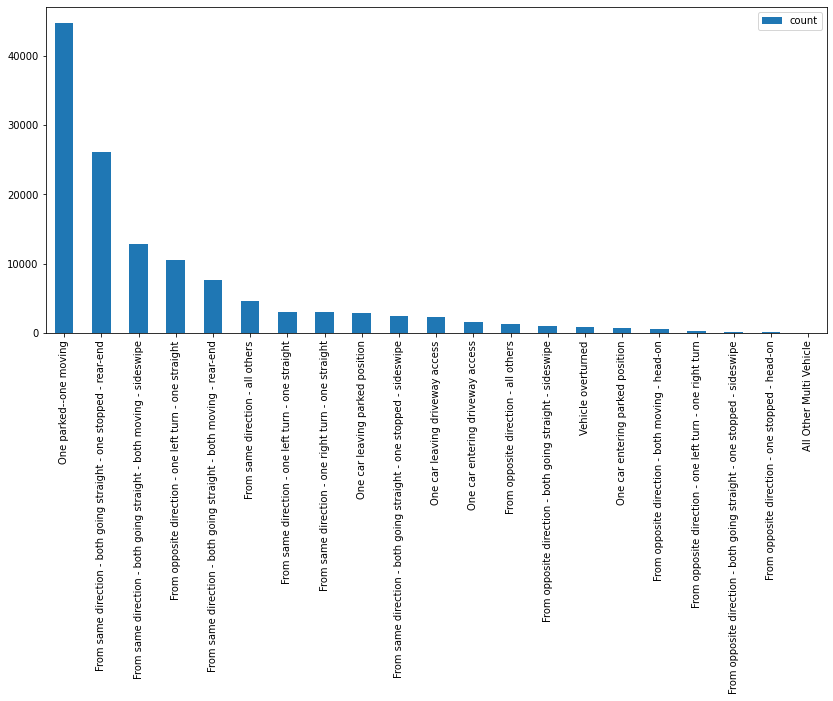

In [30]:
vehicle_only_df['st_coldesc'].value_counts().to_frame('count').plot.bar(figsize=(14, 6))

## Merge with GEOJSON
Using geopandas to join our collisions dataset to the Census file using our x/y coordinates.


In [36]:
# Create a dataframe that includes a new feature called geometry, which is basically a point made from x & y           
gdf_collisions = gpd.GeoDataFrame(df_new, geometry=gpd.points_from_xy(df_new.x, df_new.y))
# This will show the newly created geometry geo feature
gdf_collisions.head(1)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,st_colcode,st_coldesc,hitparkedcar,fe_exists,time,total_injuries,total_person_count,fe_emd,cluster,geometry
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,...,3,Vehicle backing hits pedestrian,N,1,18:36,1,3,False,0,POINT (-122.34047 47.60863)


In [37]:
# Open the Census Tracts Geo file
geojson_file = "data/Census_Tracts_2010.geojson"
census_tracts = gpd.read_file(geojson_file)
census_tracts.head(1)

,OBJECTID,TRACT,TRACTCE10,GEOID10,NAME10,NAMELSAD10,ACRES_TOTAL,WATER,SHAPE_Length,SHAPE_Area,geometry
0,1,2500,002500,53033002500,25,Census Tract 25,243.219083,0,16442.968402,1.059462e+07,"POLYGON ((-122.29602 47.69023, -122.29608 47.6..."


In [38]:
# conda install rtree

In [39]:
# Join the two - a left join means we wont loose records from our collision dataset. within means the x/y pont must be contained within the census polygon
df_with_geo = gpd.sjoin(gdf_collisions, census_tracts, how="left", op="within")

In [40]:
# Make sure it was a left join and we didn't loose any records
print("Original df shape:", df_new.shape)
print("New df shape:", df_with_geo.shape)

Original df shape: (220436, 39)
New df shape: (220436, 50)


In [41]:
# Drop un-needed columns
df_with_geo.drop(['OBJECTID', 'TRACT', 'TRACTCE10', 'GEOID10', 'NAME10', 'WATER', 'geometry', 'SHAPE_Area', 'SHAPE_Length', 'ACRES_TOTAL', 'index_right', 'SHAPE_Length', 'SHAPE_Area'],axis=1, inplace=True)
df_with_geo.head(1)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,st_colcode,st_coldesc,hitparkedcar,fe_exists,time,total_injuries,total_person_count,fe_emd,cluster,NAMELSAD10
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,...,3,Vehicle backing hits pedestrian,N,1,18:36,1,3,False,0,Census Tract 81


In [42]:
df_with_geo.columns = df_with_geo.columns.str.lower()

## Merge with Neighborhood Csv
Mergin with this dataset (created using Tableau) which contains the neighborhood for each census group

In [43]:
# Now we can pull neighborhood from the csv I created from tableau

df_neighborhood = pd.read_csv('data/location_neighborhood_census_area.csv')
df_neighborhood.shape

(135, 2)

In [44]:
df_with_geo_neighborhood = pd.merge(df_with_geo, df_neighborhood, on='namelsad10', how='left')

In [45]:
df_with_geo_neighborhood.head(1)

,x,y,objectid,addrtype,intkey,location,severitycode,severitydesc,collisiontype,personcount,...,st_coldesc,hitparkedcar,fe_exists,time,total_injuries,total_person_count,fe_emd,cluster,namelsad10,neighborhood
0,-122.340472,47.608629,1,Intersection,29598.0,PIKE PL AND PIKE ST,2,Injury Collision,Pedestrian,2,...,Vehicle backing hits pedestrian,N,1,18:36,1,3,False,0,Census Tract 81,Downtown / Waterfront


In [46]:
# Rename census area column to something that makes more sense
df_with_geo_neighborhood=df_with_geo_neighborhood.rename(columns = {'namelsad10':'census_area'})

In [47]:
# Make sure it was a left join and we didn't loose any records
print("Original df shape:", df_new.shape)
print("New df shape:", df_with_geo_neighborhood.shape)

Original df shape: (220436, 39)
New df shape: (220436, 40)


In [48]:
# rename dataframe back to what we were using before
df_new=df_with_geo_neighborhood

## Impute missing weather with date and census area
If that doesn't work, then we will try neighborhood

In [49]:
# Define a Named Tuple Here so that we can use it in the rest of the notebook

DateArea = namedtuple("DateArea", ["date", "area"])

def make_date_area_env_dict(df, date, area, env_condition):
    # Creating a dictionary that has a named tuple as the key, basically (date,area) and a dict of environmental (like weather) conditions conditions as the value
    # My intent is to count the number of environmental (like weather) conditions for the date/area combination so that the one with the highst count wins

    #Only use those records with values for all three features, date, area and environmental (like weather) conditions
    df_with_values = df[df["incdate"].notnull() & df[area].notnull() & df[env_condition].notnull()  ]
    
    # Overall Dictionary Object to track all this informaiton
    loc_date_dict = dict()
    for idx, row in df_with_values.iterrows():
        # This is my date/area tuple
        dl = DateArea(date=str(row[date]), area=row[area])
        if dl in loc_date_dict.keys():
            env_dict = loc_date_dict[dl]
            if row[env_condition] in env_dict.keys():
                env_dict[row[env_condition]] +=1
            else:
                env_dict[row[env_condition]]=1
                loc_date_dict[dl]=env_dict
        else:
            env_dict = dict()
            env_dict[row[env_condition]]  = 1
            loc_date_dict[dl]= env_dict
    return loc_date_dict

In [50]:
# Create Dictionary using date, census area for the named tuple (key) and a dictionary of the most common weather conditions for the value
dict_date_census_weather = make_date_area_env_dict(df_new, "incdate", "census_area", "weather")
count_imputed=0

In [51]:
# How many records do we have where weather is null, but date and census area are not
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(38560, 40)

In [52]:
# Take a look at the first 15 items of our imputing dictionary
first_5=0
for key, value in dict_date_census_weather.items() :
    if first_5<5: print(key)
    if first_5<5: print(value)    
    first_5+=1

DateArea(date='2004-10-14 00:00:00', area='Census Tract 81')
{'Overcast': 1, 'Unknown': 2, 'Clear': 1}
DateArea(date='2020-01-22 00:00:00', area='Census Tract 119')
{'Unknown': 1}
DateArea(date='2020-01-05 00:00:00', area='Census Tract 12')
{'Raining': 1}
DateArea(date='2020-02-13 00:00:00', area='Census Tract 109')
{'Overcast': 1, 'Clear': 1}
DateArea(date='2020-02-08 00:00:00', area='Census Tract 47')
{'Unknown': 1}


In [53]:
#imputing missing data by neighborhood
dict_date_neighborhood_weather = make_date_area_env_dict(df_new, "incdate", "neighborhood", "weather")

In [54]:
# Take a look at the first 15 items of our imputing dictionary
first_5=0
for key, value in dict_date_neighborhood_weather.items() :
    if first_5<5: print(key)
    if first_5<5: print(value)    
    first_5+=1

DateArea(date='2004-10-14 00:00:00', area='Downtown / Waterfront')
{'Overcast': 1, 'Unknown': 4, 'Clear': 3}
DateArea(date='2020-01-22 00:00:00', area='Rainier Beach / Dunlap')
{'Unknown': 1}
DateArea(date='2020-01-05 00:00:00', area='Northgate')
{'Raining': 1}
DateArea(date='2020-02-13 00:00:00', area='Georgetown')
{'Overcast': 1, 'Clear': 1}
DateArea(date='2020-02-08 00:00:00', area='Ballard')
{'Unknown': 2}


In [55]:
# This function will be used in our lambda expression below. It will try to fill weather with the most common weather condition for the date/census area combo

def find_env_val(dict_env,area_string, date_string, old_val, debug=False):
    dl = DateArea(date=str(date_string), area=area_string)
    if (str(old_val)=="nan" or str(old_val)=="Unknown") and dl in dict_env.keys():  
        env_dict = dict_env[dl]
        # Now we want to find the key of the item in env_dic that has the greatest value (count) and use it to replace our NaN value
        # If they all have equal, then the value selected is kind of random (order that it was added to dictionary)
        new_val = max(env_dict, key=env_dict.get)
        if (debug) and  len(env_dict.keys()) >1: print(f"Filling in env for {area_string}, and {date_string} with {new_val} using this info {env_dict}")
    else:
        new_val = old_val
    #print(f"{area_string}  {newX},{newY}")
    return new_val

In [56]:
df_new['weather'] = df_new.apply(lambda x: find_env_val(dict_date_neighborhood_weather,area_string=x['neighborhood'],date_string=str(x['incdate']), old_val=x['weather'],debug=False), axis=1)

In [57]:
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(24455, 40)

In [58]:
#impute remaining using city
df_new['city']="seattle"

In [59]:
dict_date_city_weather = make_date_area_env_dict(df_new, "incdate", "city", "weather")

In [60]:
df_new['weather'] = df_new.apply(lambda x: find_env_val(dict_date_city_weather,area_string=x['city'],date_string=str(x['incdate']), old_val=x['weather'],debug=False), axis=1)

In [61]:
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(2250, 41)

In [62]:
most_common_value=df_new['weather'].value_counts().index[0]
print(most_common_value)

Clear


In [63]:
df_new['weather'].fillna(most_common_value, inplace=True)
df_new['weather'].replace(['Unknown'], most_common_value, inplace=True)

In [64]:
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "weather"]=="Unknown") | (df_new[ "weather"].isnull())) ]
df_no_weather.shape

(0, 41)

In [65]:
#imputing for road conditions using neighborhoods
dict_date_neighborhood_roadcond = make_date_area_env_dict(df_new, "incdate", "neighborhood", "roadcond")

In [66]:
df_new['roadcond'] = df_new.apply(lambda x: find_env_val(dict_date_neighborhood_weather,area_string=x['neighborhood'],date_string=str(x['incdate']), old_val=x['roadcond'],debug=False), axis=1)
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "roadcond"]=="Unknown") | (df_new[ "roadcond"].isnull())) ]
df_no_weather.shape

(23476, 41)

In [67]:
dict_date_city_roadcond = make_date_area_env_dict(df_new, "incdate", "city", "roadcond")

In [68]:
df_new['roadcond'] = df_new.apply(lambda x: find_env_val(dict_date_city_weather,area_string=x['city'],date_string=str(x['incdate']), old_val=x['roadcond'],debug=False), axis=1)
df_no_weather = df_new[df_new["incdate"].notnull() & df_new["census_area"].notnull() & ((df_new[ "roadcond"]=="Unknown") | (df_new[ "roadcond"].isnull())) ]
df_no_weather.shape

(2207, 41)

In [69]:
most_common_value=df_new['roadcond'].value_counts().index[0]
df_new['roadcond'].fillna(most_common_value, inplace=True)
df_new['roadcond'].replace(['Unknown'], most_common_value, inplace=True)

In [70]:
#exporting to a csv, this will overwrite when more people fill in their nulls
df_new.to_csv('collisions_clean.csv')

In [71]:
df_new.shape

(220436, 41)

In [72]:
df_new.columns

Index(['x', 'y', 'objectid', 'addrtype', 'intkey', 'location', 'severitycode',
       'severitydesc', 'collisiontype', 'personcount', 'pedcount',
       'pedcylcount', 'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'incdate', 'incdttm', 'junctiontype', 'sdot_colcode', 'sdot_coldesc',
       'inattentionind', 'underinfl', 'weather', 'roadcond', 'lightcond',
       'pedrownotgrnt', 'sdotcolnum', 'speeding', 'st_colcode', 'st_coldesc',
       'hitparkedcar', 'fe_exists', 'time', 'total_injuries',
       'total_person_count', 'fe_emd', 'cluster', 'census_area',
       'neighborhood', 'city'],
      dtype='object')

In [73]:
# % nulls that we have left 
df_new.isnull().sum()/len(df_new)

x                     0.032613
y                     0.032613
objectid              0.000000
addrtype              0.000000
intkey                0.675570
location              0.020759
severitycode          0.000005
severitydesc          0.000000
collisiontype         0.000000
personcount           0.000000
pedcount              0.000000
pedcylcount           0.000000
vehcount              0.000000
injuries              0.000000
seriousinjuries       0.000000
fatalities            0.000000
incdate               0.000000
incdttm               0.000000
junctiontype          0.000000
sdot_colcode          0.000005
sdot_coldesc          0.000000
inattentionind        0.863058
underinfl             0.000000
weather               0.000000
roadcond              0.000000
lightcond             0.000000
pedrownotgrnt         0.000000
sdotcolnum            0.422939
speeding              0.000000
st_colcode            0.042702
st_coldesc            0.000000
hitparkedcar          0.000000
fe_exist